In [1]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Training with whole graph
Downsampled 90% normal traffic randomly
Split train and test randomly

Combined IP and Port features
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [2]:
csv_file_name = "all_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"
EXPERIMENT_NAME = "whole_graph_combined_ports"

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

attack_cat
Normal            221876
Generic           215481
Exploits           44525
Fuzzers            24246
DoS                16353
Reconnaissance     13987
Analysis            2677
Backdoors           2329
Shellcode           1511
Worms                174
Name: count, dtype: int64
label
1    321283
0    221876
Name: count, dtype: int64


In [3]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
data.drop(columns=UNSW_NB15_Config.TIME_COL_NAMES)
print(data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id'],
      dtype='object')


In [4]:
data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# # Combine Port and IP
data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

data = pd.get_dummies(data, columns = UNSW_NB15_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(UNSW_NB15_Config.CATEGORICAL_COLS))]

In [5]:
print(data.head)

<bound method NDFrame.head of                        srcip                  dstip        dur  sbytes  \
0             10.40.85.1_0:0          224.0.0.5_0:0  50.004341     384   
1          59.166.0.6_0:2142     149.171.126.4_0:53   0.001134     132   
2       175.45.176.0_0:13284    149.171.126.16_0:80   2.390390    1362   
3         59.166.0.3_0:42587     149.171.126.8_0:25  34.077175   37358   
4            10.40.170.2_0:0        10.40.170.2_0:0   0.000000      46   
...                      ...                    ...        ...     ...   
543154  175.45.176.1_3:17386  149.171.126.11_3:6071   0.291164     732   
543155  175.45.176.3_3:36130  149.171.126.16_3:2140   0.011751      76   
543156    59.166.0.2_3:27607     149.171.126.4_3:53   0.002410     146   
543157  175.45.176.1_3:24448  149.171.126.11_3:5250   0.176514   10778   
543158    59.166.0.2_3:10376   149.171.126.2_3:8406   0.049598    2646   

        dbytes  sttl  dttl  sloss  dloss          Sload  ...  state_ECR  \
0     

In [6]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                        srcip                  dstip        dur  sbytes  \
0             10.40.85.1_0:0          224.0.0.5_0:0  50.004341     384   
1          59.166.0.6_0:2142     149.171.126.4_0:53   0.001134     132   
2       175.45.176.0_0:13284    149.171.126.16_0:80   2.390390    1362   
3         59.166.0.3_0:42587     149.171.126.8_0:25  34.077175   37358   
4            10.40.170.2_0:0        10.40.170.2_0:0   0.000000      46   
...                      ...                    ...        ...     ...   
543154  175.45.176.1_3:17386  149.171.126.11_3:6071   0.291164     732   
543155  175.45.176.3_3:36130  149.171.126.16_3:2140   0.011751      76   
543156    59.166.0.2_3:27607     149.171.126.4_3:53   0.002410     146   
543157  175.45.176.1_3:24448  149.171.126.11_3:5250   0.176514   10778   
543158    59.166.0.2_3:10376   149.171.126.2_3:8406   0.049598    2646   

        dbytes  sttl  dttl  sloss  dloss          Sload  ...  state_ECR  \
0     

In [7]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

                 dur        sbytes        dbytes           sttl  \
count  543159.000000  5.431590e+05  5.431590e+05  543159.000000   
mean        0.703562  5.129376e+03  1.912066e+04     157.223966   
std        12.635598  1.202304e+05  1.382834e+05     108.429349   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000007  1.140000e+02  0.000000e+00      31.000000   
50%         0.000010  2.000000e+02  0.000000e+00     254.000000   
75%         0.070875  1.580000e+03  1.936000e+03     254.000000   
max      8760.776367  1.435577e+07  1.465753e+07     255.000000   

                dttl          sloss          dloss         Sload  \
count  543159.000000  543159.000000  543159.000000  5.431590e+05   
mean       38.847354       3.789714       8.637535  6.901181e+07   
std        77.059190      45.614073      49.869719  1.425974e+08   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.000000       0.000000  3.76

In [8]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [9]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [10]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)


['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoors': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [11]:
# 70% train, 15% validation, 15% test
train_full_df, test_df = train_test_split(
     data, test_size=0.15, random_state=42, stratify=data[label_col])


feature_cols = UNSW_NB15_Config.COLS_TO_NORM + converted_categorical_cols

print('Feature Columns:', feature_cols)

train_full_df['h'] = train_full_df[ feature_cols ].values.tolist()
test_df['h'] = test_df[ feature_cols ].values.tolist()

y_train = train_full_df[label_col]
y_test = test_df[label_col]

pd.set_option('display.max_columns', None)

print("Number of training samples:", len(train_full_df))
print(y_train.value_counts())
print("Number of test samples:", len(test_df))
print(y_test.value_counts())

print(train_full_df.head(5))

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH']
Number of training samples: 461685
attack_cat
6    188595
5    183159
3     37846
4     20609
2     13900
7     11889
0      2275
1      1980
8      1284
9       148
Name: count, dtype: int64
Number of test samples: 81474
attack_cat
6    33281
5    32322
3     6679
4     3637
2     2453
7     2098
0      402
1      349
8      227
9       26
Name: c

In [12]:
def create_graph(df, source_ip_col, destination_ip_col, edge_attr, create_using=nx.MultiDiGraph(), **kwargs):
    G_nx = nx.from_pandas_edgelist(df, source_ip_col, destination_ip_col, edge_attr, create_using=create_using, **kwargs)
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    print("Number of edges in G_pyg:", num_edges)
    print("Number of node in G_pyg:", num_nodes)
    print("Shape of node in G_pyg:", G_pyg.x.shape)
    print("Shape of edge attr in G_pyg:", G_pyg.edge_attr.shape)
    print("Shape of edge label in G_pyg:", G_pyg.edge_label.shape)

    return G_nx, G_pyg

In [13]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 81474
Number of node in G_pyg: 54154
Shape of node in G_pyg: torch.Size([54154, 52])
Shape of edge attr in G_pyg: torch.Size([81474, 52])
Shape of edge label in G_pyg: torch.Size([81474])


In [14]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [15]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
th.cuda.empty_cache()

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(data, epochs, learning_rates, hidden_dims, drop_outs):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds = []
    for train_idx, val_idx in skf.split(data, data[label_col]):
        train_df = data.iloc[train_idx]
        val_df = data.iloc[val_idx]

        G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
        G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

        G_pyg_train = G_pyg_train.to(device)
        G_pyg_val = G_pyg_val.to(device)

        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

        folds.append((G_pyg_train, G_pyg_val))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                fold_f1_scores = []

                for fold, (G_pyg_train, G_pyg_val) in enumerate(folds):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                                    edge_in_channels=G_pyg_train.num_edge_features,
                                    hidden_channels=hidden_dim,
                                    dropout=drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    labels = G_pyg_train.edge_label.cpu().numpy()
                    class_weights = class_weight.compute_class_weight('balanced',
                                                                    classes=np.unique(labels),
                                                                    y=labels)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        train_loss = 0
                        val_loss = 0

                        try:
                            model.train()
                            out = model(G_pyg_train)
                            
                            optimizer.zero_grad()
                            loss = criterion(out, G_pyg_train.edge_label)
                            train_loss = loss.item()

                            loss.backward()
                            optimizer.step()
                            scheduler.step()

                            model.eval()
                            with th.no_grad():
                                out = model(G_pyg_val)
                                loss = criterion(out, G_pyg_val.edge_label)
                                val_loss = loss.item()

                            val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Parameters: lr={lr}, hidden_dim{hidden_dim}, drop_out={drop_out}")

                            if epoch % 100 == 0:
                                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print("Current Results: ", params_results)
                print(f"Average F1 Score for dropout {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

grid_search(train_full_df, epochs=500, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


Number of edges in G_pyg: 307790
Number of node in G_pyg: 195382
Shape of node in G_pyg: torch.Size([195382, 52])
Shape of edge attr in G_pyg: torch.Size([307790, 52])
Shape of edge label in G_pyg: torch.Size([307790])
Number of edges in G_pyg: 153895
Number of node in G_pyg: 100146
Shape of node in G_pyg: torch.Size([100146, 52])
Shape of edge attr in G_pyg: torch.Size([153895, 52])
Shape of edge label in G_pyg: torch.Size([153895])
Number of edges in G_pyg: 307790
Number of node in G_pyg: 194910
Shape of node in G_pyg: torch.Size([194910, 52])
Shape of edge attr in G_pyg: torch.Size([307790, 52])
Shape of edge label in G_pyg: torch.Size([307790])
Number of edges in G_pyg: 153895
Number of node in G_pyg: 100550
Shape of node in G_pyg: torch.Size([100550, 52])
Shape of edge attr in G_pyg: torch.Size([153895, 52])
Shape of edge label in G_pyg: torch.Size([153895])
Number of edges in G_pyg: 307790
Number of node in G_pyg: 195087
Shape of node in G_pyg: torch.Size([195087, 52])
Shape of e

In [19]:
train_df, val_df = train_test_split(
     train_full_df, test_size=0.15, random_state=42, stratify=train_full_df[label_col])

G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())


Number of edges in G_pyg: 392432
Number of node in G_pyg: 245578
Shape of node in G_pyg: torch.Size([245578, 52])
Shape of edge attr in G_pyg: torch.Size([392432, 52])
Shape of edge label in G_pyg: torch.Size([392432])
Number of edges in G_pyg: 69253
Number of node in G_pyg: 46463
Shape of node in G_pyg: torch.Size([46463, 52])
Shape of edge attr in G_pyg: torch.Size([69253, 52])
Shape of edge label in G_pyg: torch.Size([69253])


In [28]:
import pickle


# Extract the best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.005  # Replace with the best learning_rate found
best_dropout = 0.3  # Replace with the best dropout found
epochs = 5000

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                   edge_in_channels=G_pyg_train.num_edge_features,
                   hidden_channels=best_hidden_dim,
                   dropout=best_dropout,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Compute class weights for the training dataset
labels = G_pyg_train.edge_label.cpu().numpy()
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)

# Normalize class weights
class_weights = th.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Move the graph data to the device
G_pyg_train = G_pyg_train.to(device)
G_pyg_val = G_pyg_val.to(device)

G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    train_loss = 0
    val_loss = 0

    model.train()
    out = model(G_pyg_train)

    optimizer.zero_grad()
    loss = criterion(out, G_pyg_train.edge_label)
    train_loss = loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with th.no_grad():
        out = model(G_pyg_val)
        loss = criterion(out, G_pyg_val.edge_label)
        val_loss = loss.item()

    val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')
    val_f1_micro = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='micro')
    val_f1_macro = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='macro')

    if epoch % 10 == 0 or val_f1 > best_f1:
        # Save checkpoint
        th.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_f1
        }, checkpoint_path)
        with open(train_loss_history_path, 'wb') as f:
            pickle.dump(train_loss_history, f)
        with open(val_loss_history_path, 'wb') as f:
            pickle.dump(val_loss_history, f)
        with open(val_f1_history_path, 'wb') as f:
            pickle.dump(val_f1_history, f)
        with open(saved_model_epochs_path, 'wb') as f:
            pickle.dump(saved_model_epochs, f)

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)
        saved_model_epochs.append(epoch)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

# Save the trained model
print("Model training completed and saved.")

Class weights: tensor([2.0291e+01, 2.3317e+01, 3.3215e+00, 1.2199e+00, 2.2403e+00, 2.5207e-01,
        2.4480e-01, 3.8832e+00, 3.5970e+01, 3.1145e+02], device='cuda:0')
Epoch 0 Saved best model. Best F1: 0.35675963158778856
Epoch 0, Train Loss: 2.4535, Validation Loss: 2.7107, Validation F1: 0.3568
Epoch 1 Saved best model. Best F1: 0.357916233483906
Epoch 2 Saved best model. Best F1: 0.41191112312759487
Epoch 3 Saved best model. Best F1: 0.766470940552873
Epoch 4 Saved best model. Best F1: 0.7838183514215967
Epoch 5 Saved best model. Best F1: 0.7928635232639838
Epoch 6 Saved best model. Best F1: 0.8451443101188193
Epoch 7 Saved best model. Best F1: 0.8803274807243063
Epoch 10, Train Loss: 1.2421, Validation Loss: 1.2835, Validation F1: 0.8654
Epoch 12 Saved best model. Best F1: 0.8817022162949003
Epoch 16 Saved best model. Best F1: 0.8844544200852004
Epoch 17 Saved best model. Best F1: 0.8855596008578333
Epoch 20 Saved best model. Best F1: 0.8873373456823959
Epoch 20, Train Loss: 1.06

In [38]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1
    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    average_val_f1 = np.mean(val_f1)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

2000


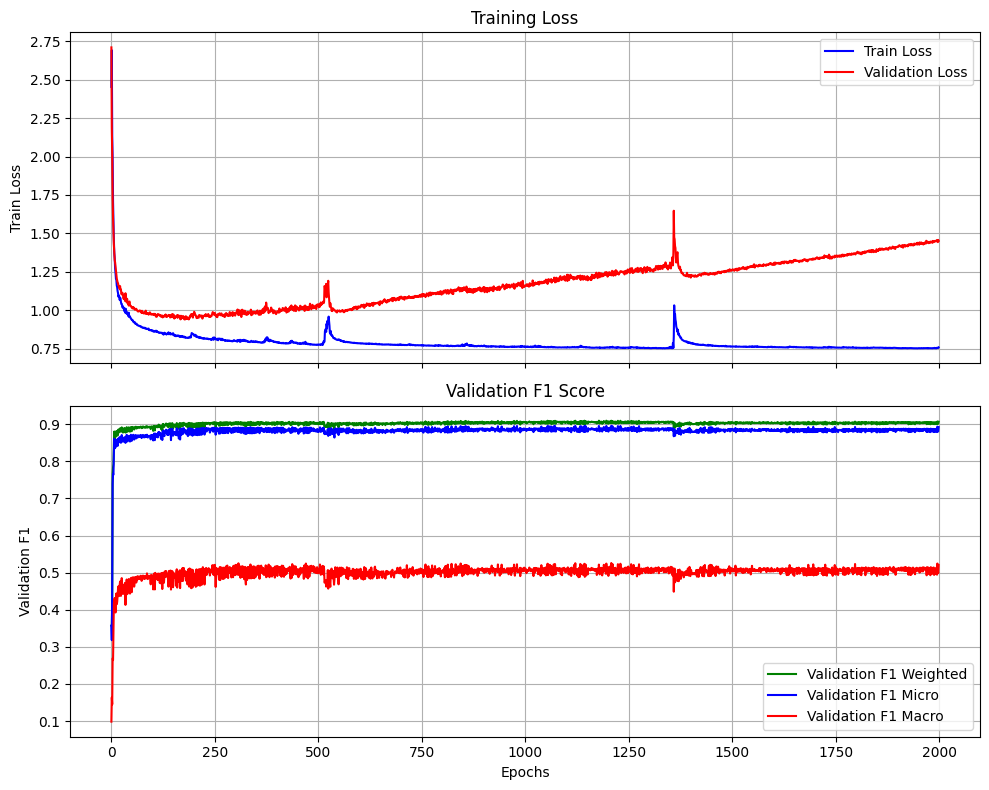

In [47]:
plot_training_process(train_loss_history[:2000], val_loss_history[:2000], val_f1_history[:2000], [])

In [48]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 81474
Number of node in G_pyg: 54154
Shape of node in G_pyg: torch.Size([54154, 52])
Shape of edge attr in G_pyg: torch.Size([81474, 52])
Shape of edge label in G_pyg: torch.Size([81474])


In [49]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(G_pyg_test, adversarial=False):

    G_pyg_test = G_pyg_test.to(device)
    G_pyg_test.edge_label = G_pyg_test.edge_label.to(device)
    G_pyg_test.edge_attr = G_pyg_test.edge_attr.to(device)

    best_model = EGraphSAGE(node_in_channels=G_pyg_test.num_node_features, 
                       edge_in_channels=G_pyg_test.num_edge_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))
    best_model = best_model.to(device)

    best_model.eval()

    print("inference start")
    with th.no_grad():
            
        try:
            out = best_model(G_pyg_test)
            
        except Exception as forward_error:
            print(f"Error during forward/backward pass at {forward_error}")

    print("inference done")

    pred_labels = out.argmax(dim=1).cpu()
    all_test_labels = G_pyg_test.edge_label.cpu()

    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]
        
        

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

    
eval(G_pyg_test)


Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   50    58   246     6     0     0     0     0     0    42]
 [    2    96   222    13     2     0     0     0    10     4]
 [   15    95  1834   205    33     6     0    11    52   202]
 [  131   219  2339  2508   122     8     4    22   132  1194]
 [   32   143   249   124  2703     2    44     0   185   155]
 [   26    16   286   229    19 31474     0     8    42   222]
 [   26     5     0    41   305     0 32837     1    29    37]
 [   21     8   296    80     4     1     0  1461    13   214]
 [    0     0     0     0     2     0     1     1   220     3]
 [    4     0     1     4     0     0     0     1     0    16]]
                precision    recall  f1-score   support

   

In [50]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        raise ValueError("No attacker nodes found.")

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [51]:
# Inject Attack Traffic to Attacker Nodes
G_pyg_test = G_pyg_test.cpu()
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=True)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done


Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  18  251  483  867  468 4583  240  793  414   30    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   20     0   313    15     0     0    41    10     0     3]
 [    1     8   253     4     2    10    67     1     3     0]
 [    7    11  1813   112    48    11   364    33    17    37]
 [   53    48  3598  14

In [52]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=False)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   2   30  154  199   35   29 7625    9   63    1    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[    0    59   122   

In [53]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [54]:
# Inject Random Nodes in the graph
injected_graph = inject_random_nodes(G_pyg_test, 0.1, num_injected_nodes=1)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  17  161  299  576  176 2077 4235  238  354   14    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   28   139   175   